<a href="https://colab.research.google.com/github/stvdll/Python-Projects/blob/main/LSTM_Stock_Predcition_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

stock = 'NVDA'
ticker = yf.Ticker(stock)

data = ticker.history(start = '2015-01-01')
data = data.dropna()


Text(0.5, 0, 'percentages')

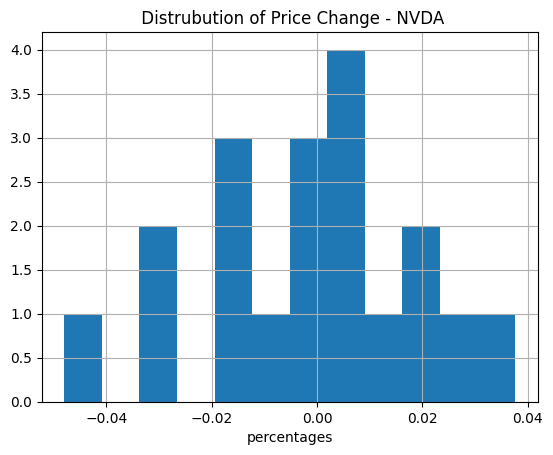

In [126]:
data['Close'].pct_change().hist(bins=12)
plt.title(f' Distrubution of Price Change - {stock}')
plt.xlabel('percentages')                                 ## Zu erkennen ist, dass die prozentuale Kursveränderung zum vorherigen Tag normalverteilt ist.
                                                        ## Gäbe es also ein Tag, wo die Aktie zu stark fällt oder steigt, würde es sich in der Theorie zum Open Price hin bewewegen
                                                        ## Modell soll die Quantile gut einschätzen können
                                                         ## Neuronale Netzwerk, soll diese Abhängigkeit in den Preisdaten erkennen
                                                      ## Es wird ein LSTM Modell verwendet, weil es Memory hat und ideal für eine Zeitreihenanalyse ist.

In [127]:
data['p Veränderung'] = data['Close'].pct_change()

data = data.dropna()


Train-Test-Split

In [128]:
scaler = MinMaxScaler()

traininput = np.array(scaler.fit_transform(data[['Close','p Veränderung']].iloc[:int(len(data)*0.8)])) #80% Train
trainoutput = np.array(data['Close'].iloc[:int(len(data)*0.8)])



testinput = np.array(scaler.transform(data[['Close','p Veränderung']].iloc[int(len(data)*0.8):]))
testoutput = np.array(data['Close'].iloc[int(len(data)*0.8):])




Sequenz

In [129]:
LOOKBACK = 3
def slidingwindow(timestep):
  input = []
  output = []

  for x in range(len(traininput)-timestep-1):

    window = traininput[x:x+timestep]

    index = 1 if trainoutput[timestep+x]> trainoutput[x + timestep-1] else 0


    input.append(window)

    output.append(index)

  return np.array(input), np.array(output)






Model training

In [130]:
x,y = slidingwindow(LOOKBACK)


model = tf.keras.Sequential([

                tf.keras.layers.LSTM(64, return_sequences= True, input_shape= (LOOKBACK, 2)),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.LSTM(32, return_sequences=False),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(16, activation = 'relu'),
                tf.keras.layers.Dropout(0.3),

                tf.keras.layers.Dense(1, activation = 'sigmoid')
])


model.compile(
  optimizer = tf.keras.optimizers.Adam (learning_rate=0.001),
  loss = 'binary_crossentropy',
  metrics = ['accuracy']
)

modelfit = model.fit(x, y, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

testings = np.array(testinput[-3:]).reshape((1, 3, 2))

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5000 - loss: 0.6933 - val_accuracy: 1.0000 - val_loss: 0.6862
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.5000 - loss: 0.6958 - val_accuracy: 1.0000 - val_loss: 0.6837
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5000 - loss: 0.6905 - val_accuracy: 1.0000 - val_loss: 0.6816
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.6250 - loss: 0.6952 - val_accuracy: 1.0000 - val_loss: 0.6800
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.6250 - loss: 0.6914 - val_accuracy: 1.0000 - val_loss: 0.6782
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6250 - loss: 0.6900 - val_accuracy: 1.0000 - val_loss: 0.6760
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6250 - loss: 0.6877 - val_accuracy: 1.0000 - val_loss: 0.6734
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6250 - loss: 0.6906 - val_accuracy: 1.0000 - val_loss: 0.6710


Text(0, 0.5, 'Accuracy')

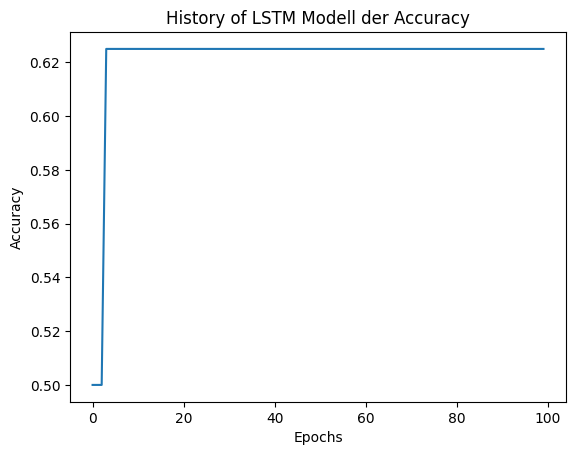

In [131]:
plt.plot(modelfit.history['accuracy'], label = 'train accuracy')
plt.title('History of LSTM Modell der Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy') ## die Accuracy wird besser

In [132]:
accuracy, loss = model.evaluate(x,y)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7273 - loss: 0.6055


In [133]:
predict = model.predict(testinput[-3:].reshape(1,3,2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


In [134]:
print(f'Model Accuracacy liegt bei {accuracy}')
print(f'Wahrscheinlichkeit, dass der Kurs morgen steigt liegt bei {predict}')

Model Accuracacy liegt bei 0.6054579019546509
Wahrscheinlichkeit, dass der Kurs morgen steigt liegt bei [[0.6013559]]
